# Volume 3: K-Means Clustering.
    Matthew Mella
    10/10/23

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from PIL import Image
from sklearn.cluster import KMeans as KM
%matplotlib inline

In [2]:
plt.rcParams["figure.dpi"] = 200

## Problem 1

Write a `KMeans` class for doing basic $k$-means clustering.
Implement the following methods.
1. `__init__()`: Accept a number of clusters $k$, a maximum number of iterations, and a convergence tolerance.
Store these as attributes.

2. `fit()`: Accept an $m \times n$ matrix $X$ of $m$ data points with $n$ features.
Choose $k$ random rows of $X$ as the initial cluster centers.
Run the $k$-means iteration until consecutive centers are within the convergence tolerance, or until iterating the maximum number of times.
Save the cluster centers as attributes.
If a cluster is empty, reassign the cluster center as a random row of $X$.

3. `predict()`: Accept an $l \times n$ matrix $X$ of data.
Return an array of $l$ integers where the $i$-th entry indicates which cluster center the $i$-th row of $X$ is closest to.

4. `plot()`: Accept an $l \times n$ matrix $X$ of $l$ data points and an array $y$ of $l$ integers representing the labels.
Plot each data point from the matrix, colored by cluster, along with the cluster centers.
Note that in this case, $n = 2$.

Test your class on the iris data set (`sklean.datasets.load_iris()`) after reducing the data to two principal components (with `sklearn.decomposition.PCA`).
Plot the data, coloring by cluster.

In [3]:
class KMeans:
    """Basic k-means clustering class."""
    def __init__(self, n_clusters=8, max_iter=100, tol=1e-5, normalize=False, p=2):
        """Store clustering algorithm parameters.
        
        Parameters:
            n_clusters (int): How many clusters to compute.
            max_iter (int): The maximum number of iterations to compute.
            tol (float): The convergence tolerance.
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.normalize = normalize
        self.p = p
    
    def compute_norm(self, x):
        return np.linalg.norm(x, axis=2, ord=self.p) if self.p != 'inf' else np.max(np.abs(x), axis=2)
    
    def fit(self, X):
        """Compute the cluster centers from random initial conditions.
        
        Parameters:
            X ((n_samples, n_features) ndarray): the data to be clustered.
        """
        sample_len = X.shape[0]
        k = self.n_clusters
        
        # Select k random rows from X
        row_indices = np.arange(sample_len)
        np.random.shuffle(row_indices)
        
        # Initialize centers
        centers = X[row_indices[:k], :]
        
        cluster_assignment = np.empty(sample_len, dtype=np.int64)

        for i in range(self.max_iter):
            # create difference tensor, then take the norm to get each samples distance from each center
            distance_tensor = self.compute_norm(X[:, np.newaxis] - centers)
            cluster_assignment = np.argmin(distance_tensor, axis=1)
            

            new_centers = np.empty_like(centers)
            # Update cluster centers
            for cluster_idx in range(k):
                cluster_samples = X[cluster_assignment == cluster_idx]
                if cluster_samples.shape[0] > 0:  # Avoid empty clusters
                    new_centers[cluster_idx] = np.mean(cluster_samples, axis=0)

            if np.linalg.norm(centers - new_centers) < self.tol:
                break
            
            centers = new_centers
            
        self.centers = centers
        # normalizes the data, converting zeros to ones
        if self.normalize:
            norms = np.linalg.norm(self.centers, axis=1)[:, np.newaxis]
            norms[norms == 0] = 1
            self.centers = centers / norms
        return self

    
    def predict(self, X):
        """Classify each entry of X based on which cluster center it belongs to.

        Parameters:
            X ((n_samples, n_classes) ndarray): the data to be clustered.
        
        Returns:
            ((n_samples) ndarray): Integer labels from 0 to n_clusters for each entry of X.
        """
        # calculate the distances, then cluster the data accordingly
        distance_tensor = self.compute_norm(X[:, np.newaxis] - self.centers)
        return np.argmin(distance_tensor, axis=1)
    
    def fit_predict(self, X):
        """Fit to the data and return the resulting labels.

        Parameters:
            X ((n_samples, n_classes) ndarray): the data to be clustered.
        """
        return self.fit(X).predict(X)
    
    def plot(self, X, y, title, xaxis, yaxis):
        """Plot each of the data points, colored by cluster.
        Plot each of the cluster centers using a different marker.

        Parameters:
            X ((n_samples, n_classes) ndarray): the data being clustered.
            y ((n_samples) ndarray): the labels for each of the samples.
        """
        # create scatter plots and show them
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=5)
        plt.scatter(self.centers[:, 0], self.centers[:, 1], c='red', marker='x', label='Cluster Centers')
        plt.title(title)
        plt.xlabel(xaxis)
        plt.ylabel(yaxis)
        plt.legend()
        plt.show()

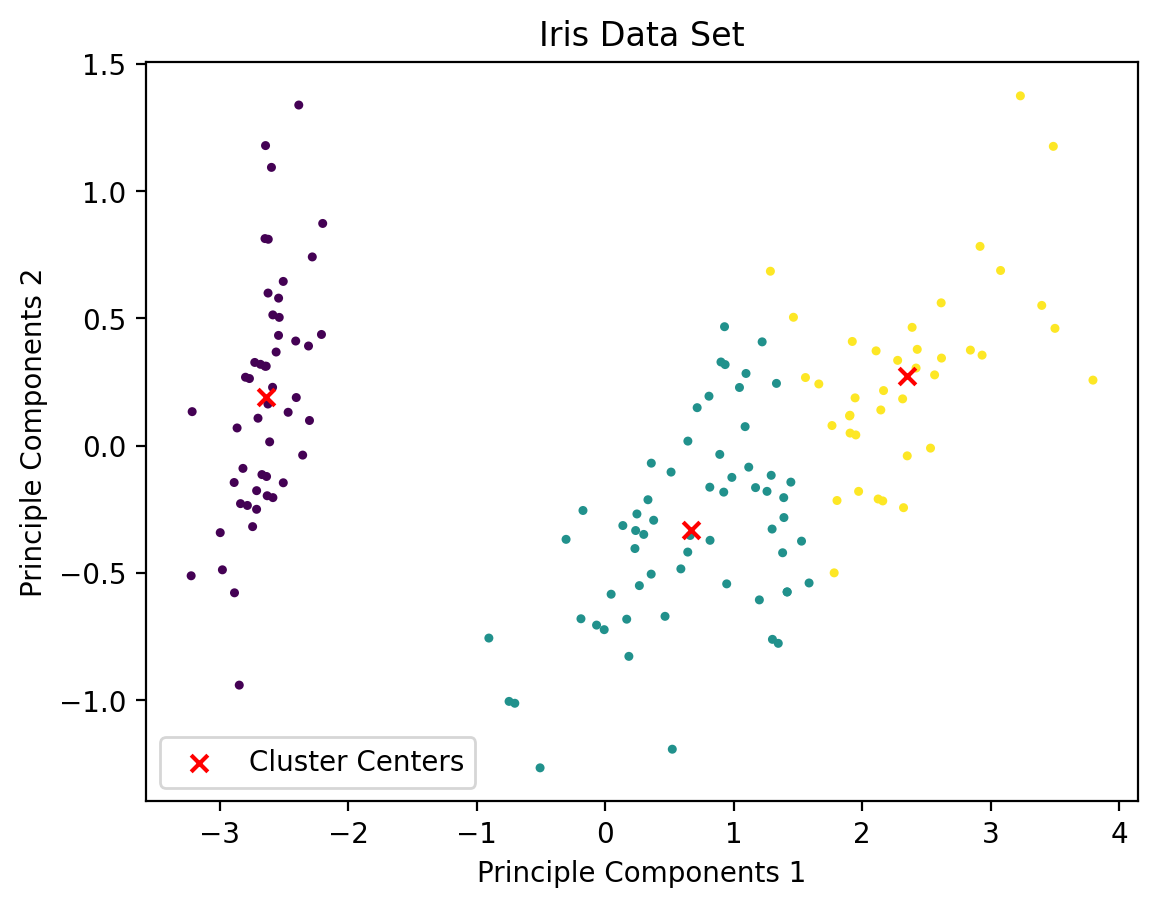

In [4]:
# Load the Iris dataset
iris = load_iris()
raw_X= iris.data

# Reduce data to 2 principal components
pca = PCA(n_components=2)
X = pca.fit_transform(raw_X)

# Initialize and fit the KMeans model
kmeans_model = KMeans(n_clusters=3, max_iter=300, tol=1e-4)

# Predict the labels
predicted_labels = kmeans_model.fit_predict(X)

kmeans_model.plot(X, predicted_labels, 'Iris Data Set', 'Principle Components 1', 'Principle Components 2')


## Problem 2
Using the Methods you wrote in Problem 1, add a parameter, $p$, to your class that denotes the norm and defaults to 2.
Save p as an attribute to be used in your fit() and predict() functions.
Using the latitude and longitude data in $\text{sacramento.npy}$ find the optimal placement for 12 fire stations. 
Plot the longitude and latitudes, the centers, and color them by cluster.
Make plots for different values for $p$ to find the optimal locations for the fire stations.
In a Markdown cell report which norm was the best at keeping the maximum distance small.

In [5]:
def sacramento_model(X, p):
    # create model
    kmeans_model = KMeans(n_clusters=12,p=p)
    # fit and then predict the original data
    X_labels = kmeans_model.fit_predict(X)
    # plot the data
    kmeans_model.plot(X, X_labels, f'Sacramento Fire Stations, p = {p}', 'Longitude', 'Latitude')
    centers = kmeans_model.centers
    cluster_data = [X[X_labels == i] for i in range(kmeans_model.n_clusters)]
    # return the norm of the vector containing all max differences
    return np.linalg.norm(np.array([np.max(cluster - centers[i]) for i, cluster in enumerate(cluster_data)]))


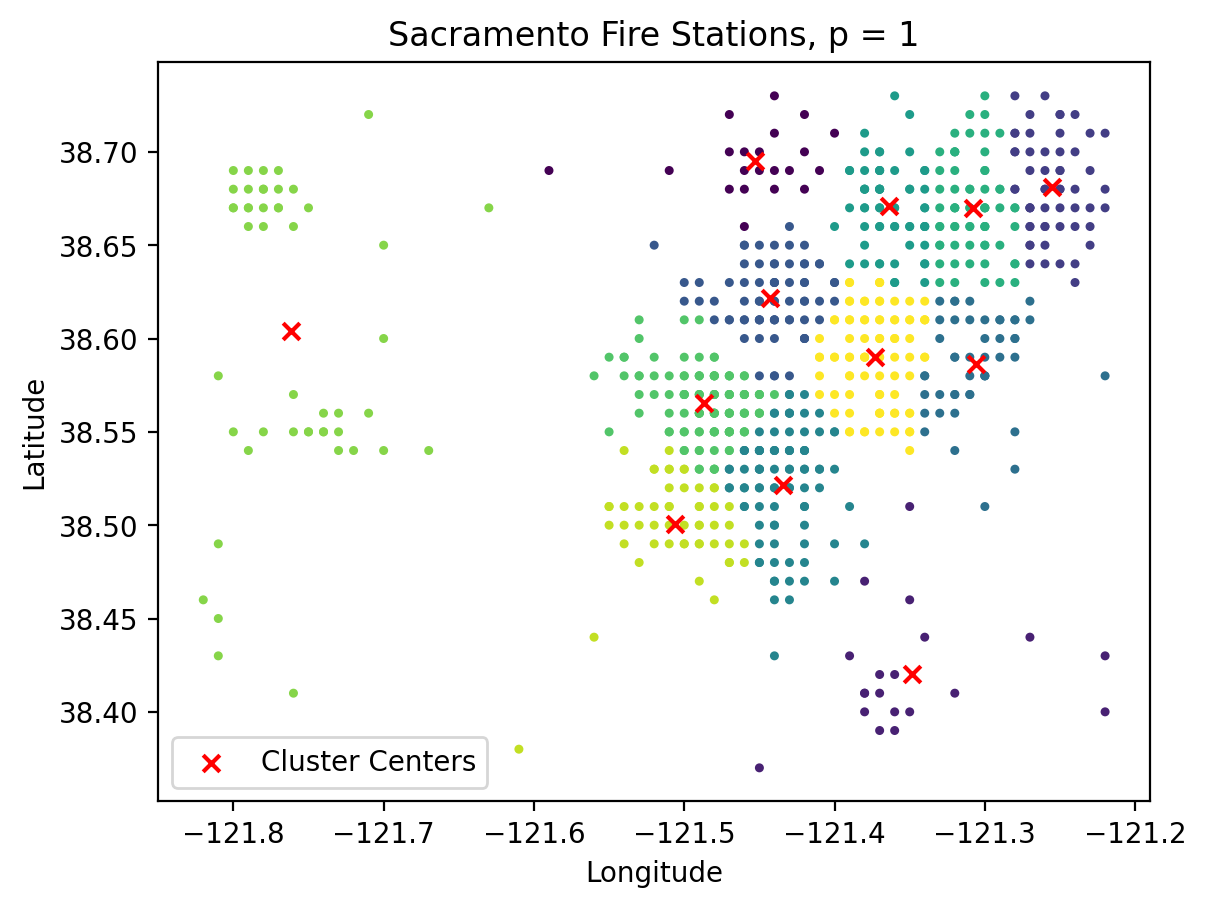

Norm of max distance for each clusters 0.2534187466253868


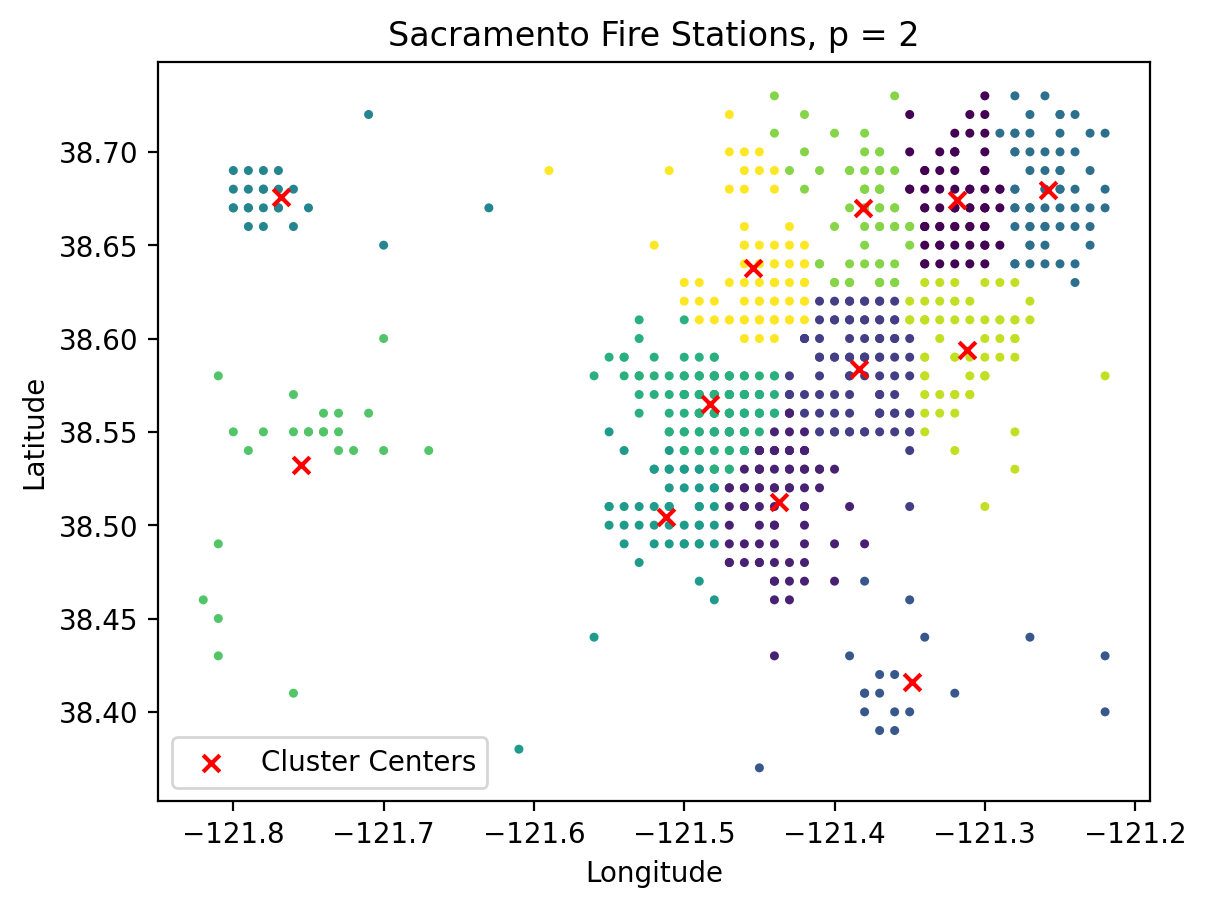

Norm of max distance for each clusters 0.27584393377762534


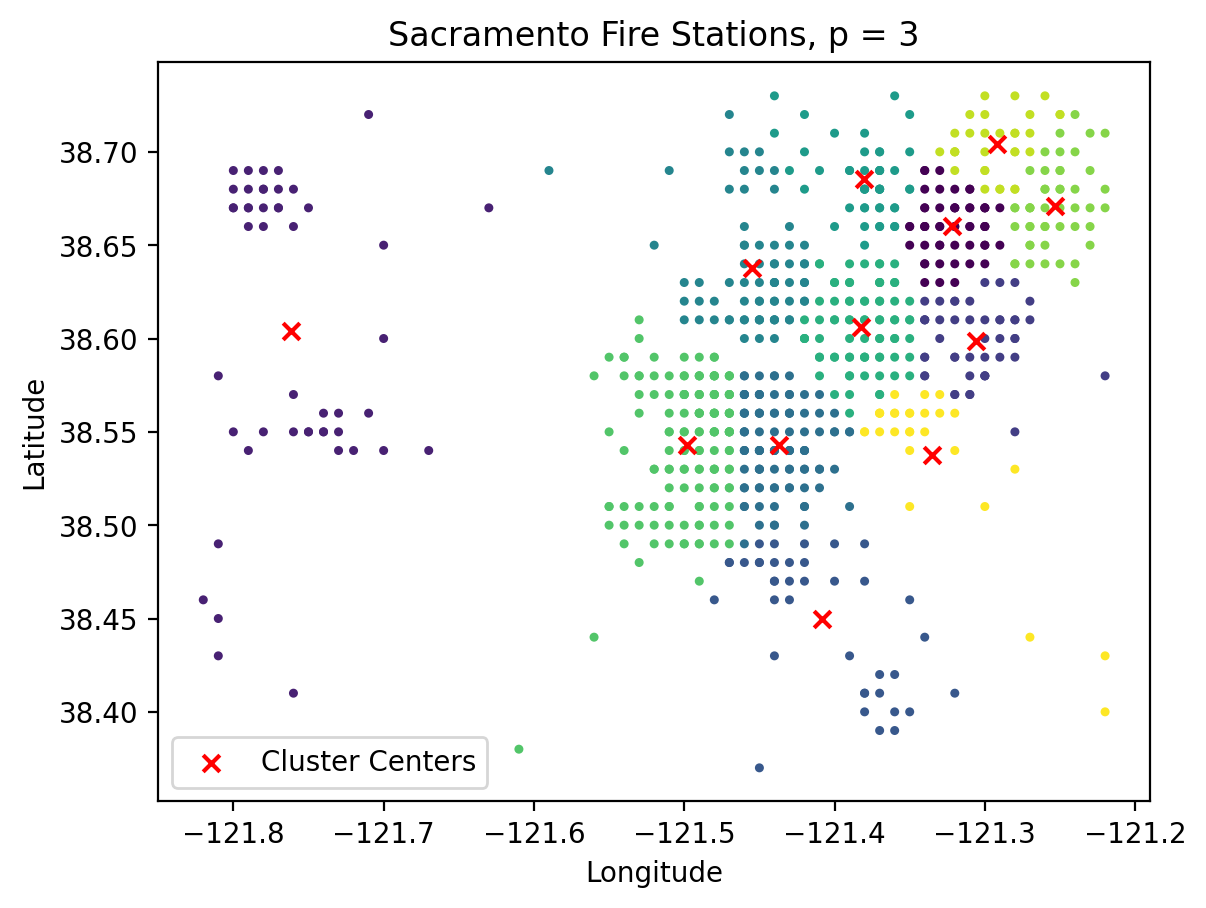

Norm of max distance for each clusters 0.2601511459556584


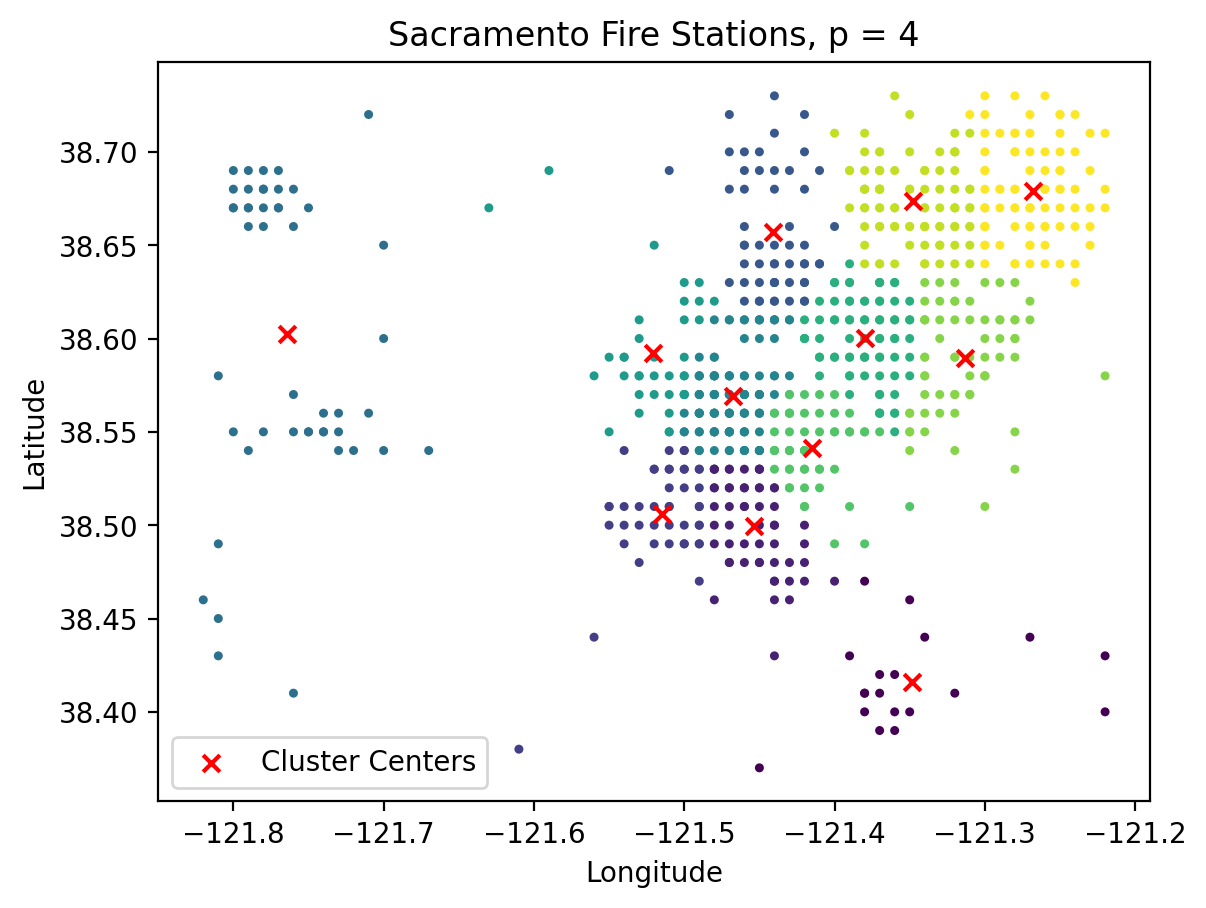

Norm of max distance for each clusters 0.2666204288324976


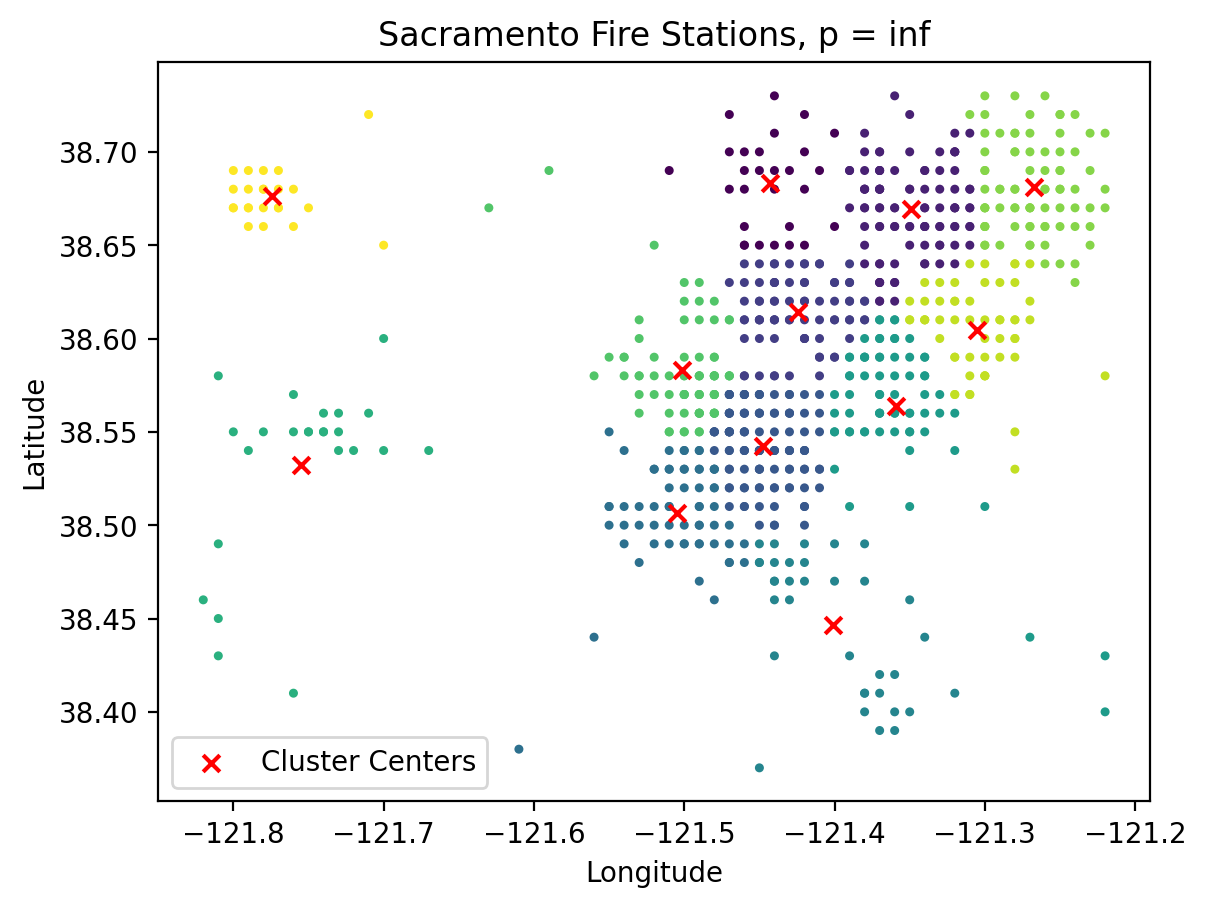

0.26639742503161556


In [21]:
X = np.load('sacramento.npy')[:,-2:][:, ::-1]
for i in range(1,5):
    print("Norm of max distance for each clusters", sacramento_model(X,i))

print(sacramento_model(X,'inf'))


It looks like the 1-norm is best suited to this minimization

## Problem 3

Modify `KMeans.fit()` so that if `normalize` is `True`, the cluster centers are normalized at each iteration.

Cluster the earthquake data in three dimensions by converting the data from spherical coordinates to euclidean coordinates on the sphere.
1. Convert longitude and latitude to radians, then to spherical coordinates.
(Hint: `np.deg2rad()` may be helpful.)
2. Convert the spherical coordinates to euclidean coordinates in $\mathbb{R}^3$.
3. Use your `KMeans` class with normalization to cluster the euclidean coordinates.
4. Translate the cluster center coordinates back to spherical coordinates, then to degrees.
5. Plot the data, coloring by cluster.
Also mark the cluster centers.

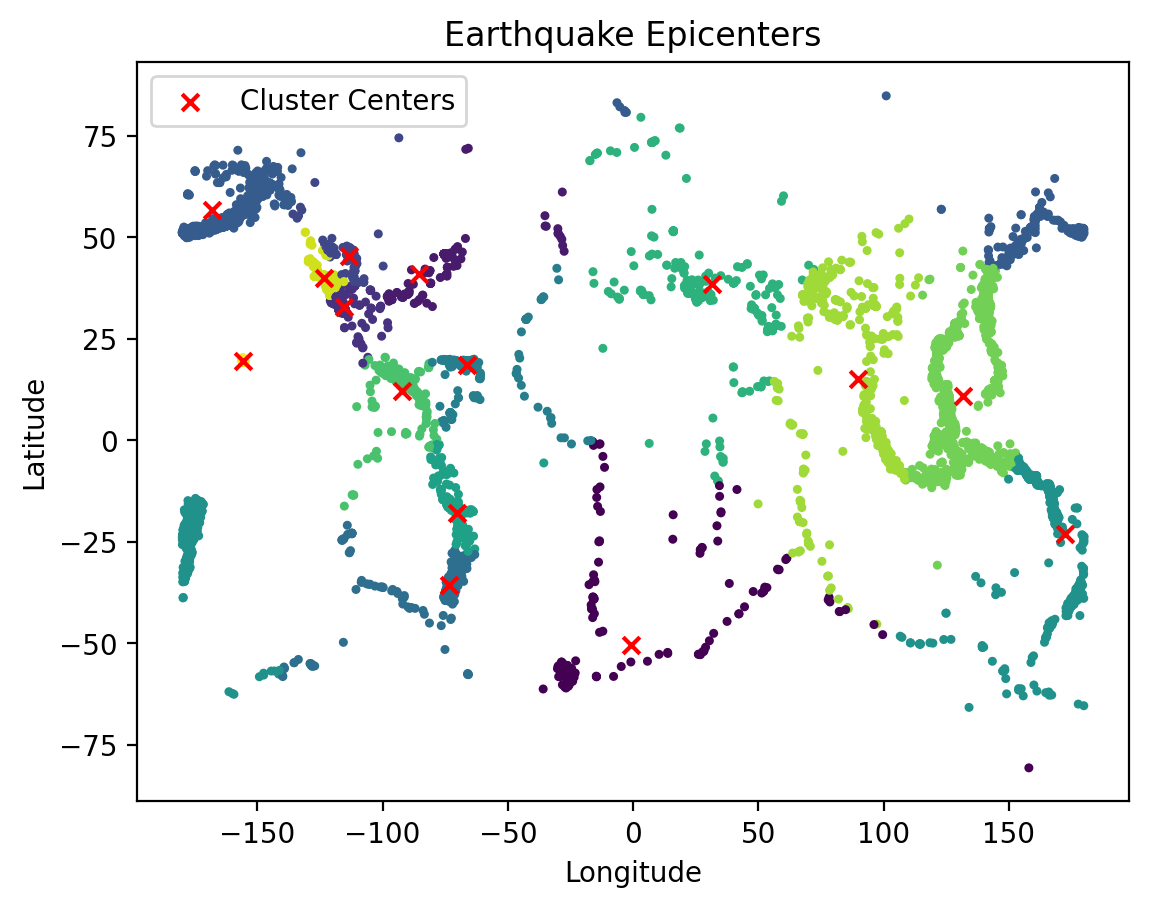

In [7]:
data = np.load('earthquake_coordinates.npy')

theta = np.deg2rad(data[:,0])
phi = np.deg2rad(90 - data[:,1])

x = np.sin(phi)*np.cos(theta)
y = np.sin(phi)*np.sin(theta)
z = np.cos(phi)

X = np.array([x,y,z]).T


model = KMeans(15, normalize=True)
X_labels = model.fit_predict(X)

centers = model.centers

longitude = np.rad2deg(np.arctan2(centers[:,1], centers[:,0]))
latitude = 90 - np.rad2deg(np.arccos(centers[:,2]))

model.centers = np.array([longitude, latitude]).T
model.plot(data, X_labels, 'Earthquake Epicenters', 'Longitude', 'Latitude')





## Problem 4

Write a function that accepts an image array (of shape $(m,n,3)$), an integer number of clusters $k$, and an integer number of samples $S$.
Reshape the image so that each row represents a single pixel.
Choose $S$ pixels to train a $k$-means model on with $k$ clusters.
Make a copy of the original picture where each pixel has the same color as its cluster center.
Return the new image.
For this problem, you may use `sklearn.cluster.KMeans` instead of your `KMeans` class.

Test your function on some of the provided NASA images.

In [8]:
def quantize_image(im, n_clusters=4, n_samples=50):
    """Cluster the pixels of the image 'im' by color.
    Return a copy of the image where each pixel is replaced by the value
    of its cluster center.
    
    Parameters:
        im ((m,n,3) ndarray): an image array.
        n_clusters (int): the number of k-means clusters.
        n_samples (int): the number of pixels to train the k-means model on.
    
    Returns:
        ((m,n,3) ndarray): the quantized image.
    """
    m,n,p = im.shape
    X = im.reshape(-1, 3)
    
    # Select n_samples random pixels to cluster around
    random_idxs = np.random.choice(X.shape[0], size=n_samples, replace=False)
    samples = X[random_idxs,:]
    # create the model
    model = KM(n_clusters,n_init="auto")
    # fit model on the sambles
    model.fit(samples)
    # cluster all of the pixels
    im_labels = model.predict(X)

    # return the image with clustered pixels replaced with the center rgb values
    return model.cluster_centers_[im_labels].reshape(m, n, p).astype(np.uint8)
    

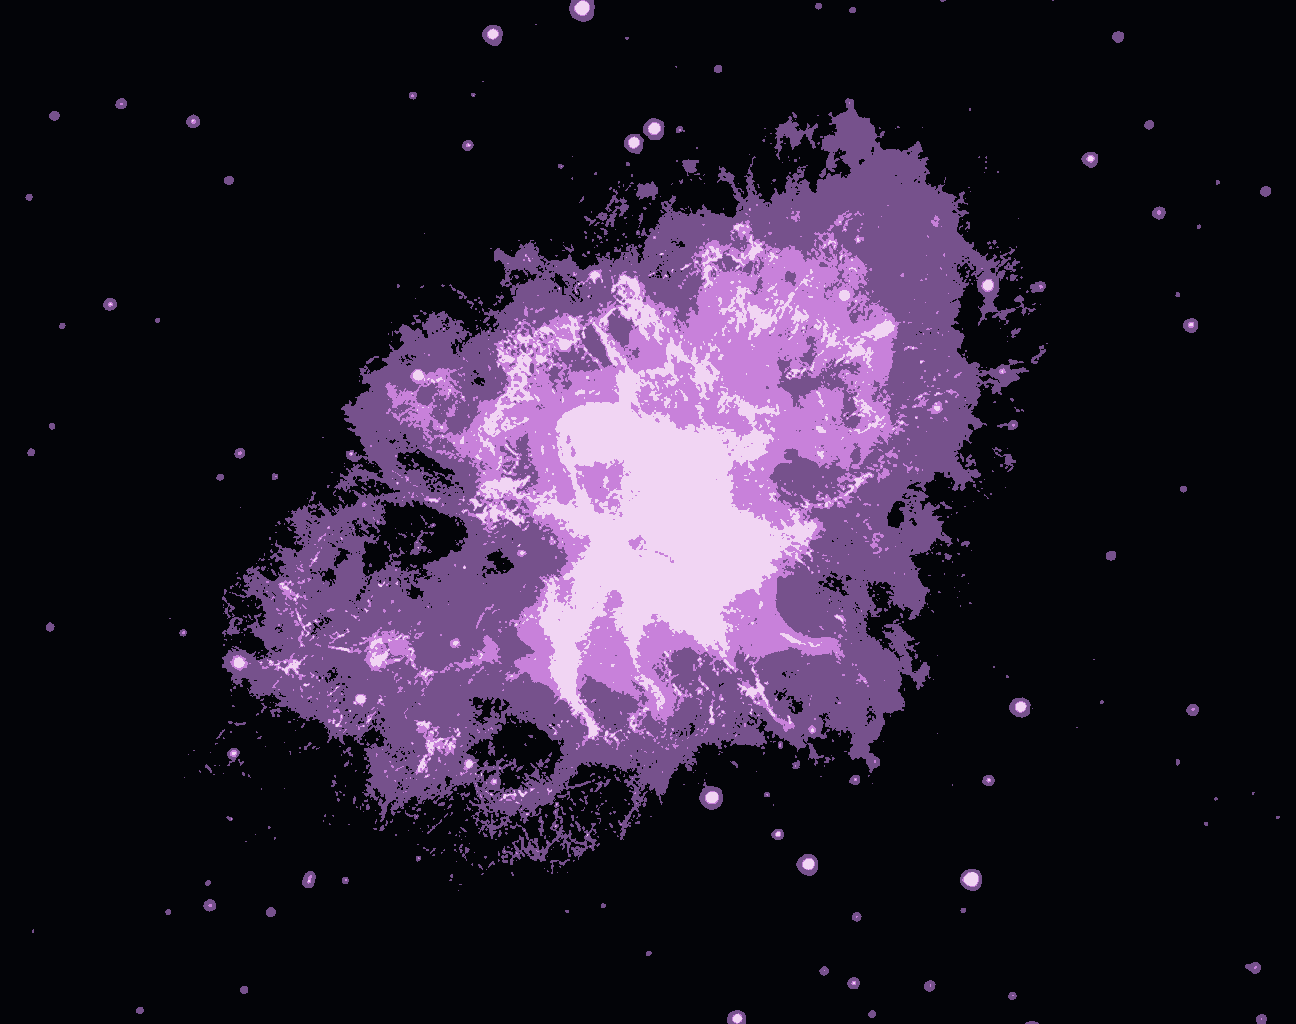

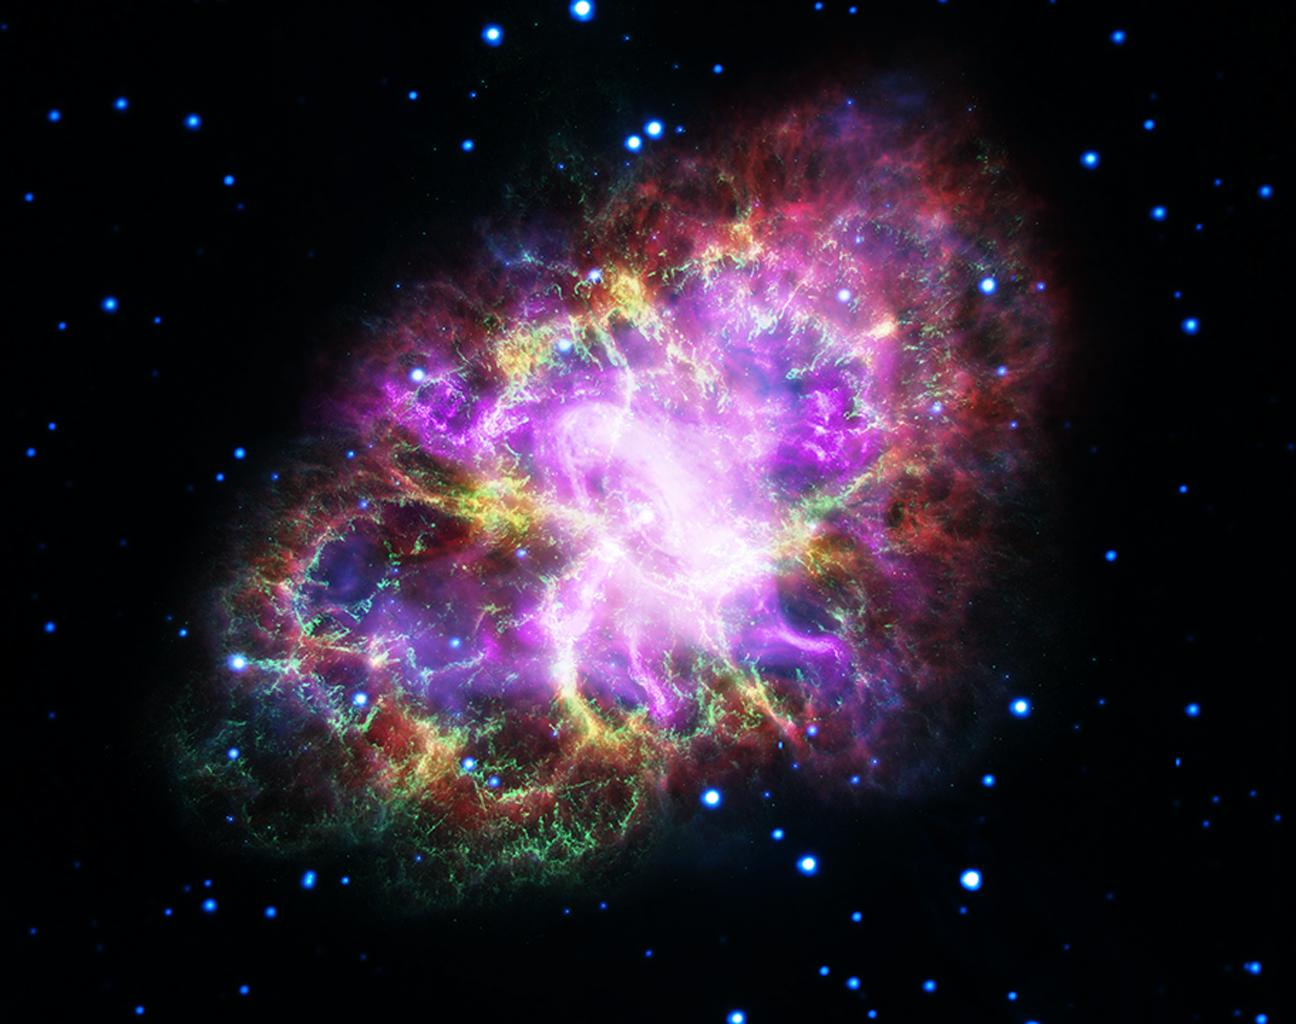

In [15]:
image = Image.open('nasa/crab_nebula.jpg')

image_array = np.array(image)

compressed_image = Image.fromarray(quantize_image(image_array), 'RGB')

display(compressed_image, image)